In [ ]:
# Install necessary packages
!pip install together
!pip install huggingface_hub
!pip install datasets
!pip install python-dotenv
!pip install transformers tensorflow
from together import Together
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sentence_transformers import SentenceTransformer, util
import numpy as np
import torch
from transformers import pipeline
from datasets import load_dataset
import os
from dotenv import load_dotenv

#Import necessary files
import config

In [9]:
#Authenticate
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Load dataset
data = load_dataset(config.DATASET_NAME)
train_data = data['train']
df = train_data.to_pandas()
print(df.head())

                                               title  \
0  Non-contrast CT synthesis using patch-based cy...   
1  Explainable COVID-19 Detection Based on Chest ...   
2  COVID-19 Severity Prediction from Chest X-ray ...   
3  Deep learning-based technique for lesions segm...   
4  MediNet: transfer learning approach with MediN...   

                                            abstract  \
0  Handcrafted and deep learning (DL) radiomics a...   
1  COVID-19,which is caused by the severe acute r...   
2  The COVID-19 pandemic has been adversely affec...   
3  Since 2019, COVID-19 disease caused significan...   
4  The rapid development of machine learning has ...   

                             journal       date  \
0                 Scientific reports 2023-06-30   
1                            Viruses 2023-06-28   
2         Journal of digital imaging 2023-06-28   
3  Multimedia tools and applications 2023-06-26   
4  Multimedia tools and applications 2023-06-26   

                   

In [11]:
# Check for missing values
print("Missing Values in Each Column:")
print(df.isnull().sum())
# Analyze publication dates
df['date'] = pd.to_datetime(df['date'])  # Convert to datetime
print("\nEarliest Publication Date:", df['date'].min())
print("Latest Publication Date:", df['date'].max())
unique_counts = df['journal'].value_counts()
print(unique_counts)

Missing Values in Each Column:
title        0
abstract    15
journal      0
date         0
authors      0
doi          1
dtype: int64

Earliest Publication Date: 2019-11-22 00:00:00
Latest Publication Date: 2023-06-30 00:00:00
journal
Computers in biology and medicine                                                                                                          74
Scientific reports                                                                                                                         56
PloS one                                                                                                                                   33
IEEE journal of biomedical and health informatics                                                                                          30
Sensors (Basel, Switzerland)                                                                                                               28
                                                       

In [12]:
# Preprocess dataset
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)  # Keep only letters and spaces
    words = word_tokenize(text)
    return " ".join([word for word in words if word not in stop_words])

# Clean and combine title and abstract
df['cleaned_title'] = df['title'].fillna("").apply(preprocess_text)
df['cleaned_abstract'] = df['abstract'].fillna("").apply(preprocess_text)
df['combined_text'] = (df['title'].fillna('') + " " + df['abstract'].fillna('')).str.strip()
df['cleaned_combined_text'] = df['combined_text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Average Abstract Length (in words): 140.01739130434783


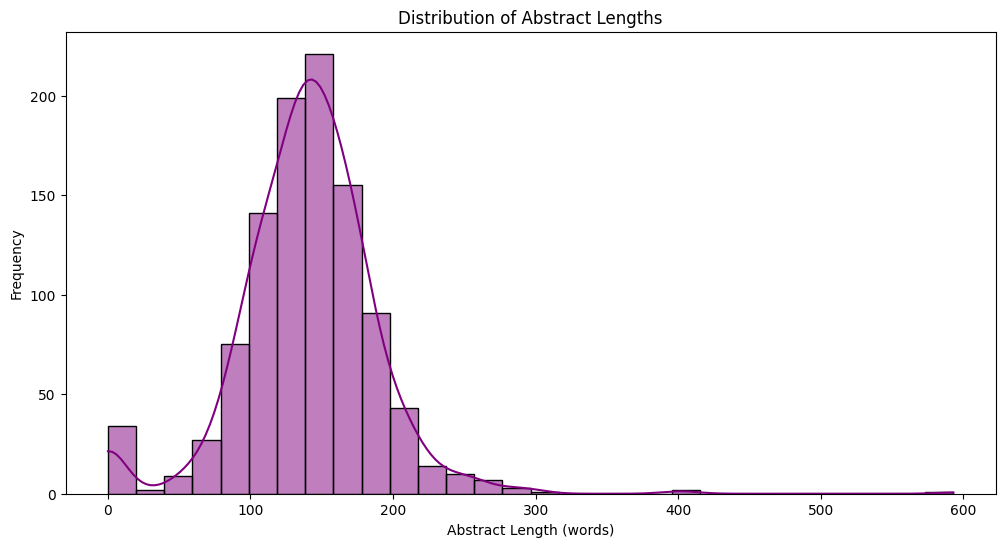

In [ ]:
# Check average abstract length
df['abstract_length'] = df['cleaned_abstract'].apply(lambda x: len(str(x).split()))
avg_abstract_length = df['abstract_length'].mean()
print("\nAverage Abstract Length (in words):", avg_abstract_length)
plt.figure(figsize=(12, 6))
sns.histplot(df['abstract_length'], bins=30, kde=True, color='purple')
plt.title("Distribution of Abstract Lengths")
plt.xlabel("Abstract Length (words)")
plt.ylabel("Frequency")
plt.savefig(config.ABS_IMAGE_PATH, dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Vectorize the combined text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['cleaned_combined_text'])

# Perform KMeans clustering to group similar papers
n_clusters = len(df) // 100  # Approximate 100 rows per group
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['similarity_group'] = kmeans.fit_predict(X)

# Check how the data is grouped
print(df['similarity_group'].value_counts())

similarity_group
3    224
9    174
2    130
7    116
5     89
0     87
4     81
6     72
8     36
1     26
Name: count, dtype: int64


In [ ]:
# Step 1: Generate ideas for each cluster
# Initialize Together client
api_key = os.getenv("TOGETHER_API_KEY")
client = Together(api_key=api_key)
def generate_ideas_for_cluster(cluster_df, group_num, subgroup_num=None):
    combined_corpus = " ".join(cluster_df['cleaned_combined_text'].tolist())
    print(f"Corpus length for Group {group_num}, Subgroup {subgroup_num if subgroup_num is not None else 'N/A'}: {len(combined_corpus)}")

    generation_prompt = (
        f"Analyze the following research corpus and identify:"
        f" 1) One or two Gaps in existing research."
        f" 2) One or two Potential unexplored areas."
        f" 3) One or two Improvements to existing ideas."
        f"Provide a comprehensive response with bullet points for each of the three aspects.\n\nCorpus: {combined_corpus[:5000]}..."  # Truncate to prevent prompt length overflow
    )

    # Send the request to Together model
    stream = client.chat.completions.create(
        model=config.GENERATION_MODEL,
        messages=[{"role": "user", "content": generation_prompt}],
        stream=True,
    )

    # Process the streamed response to get ideas
    generated_ideas = ""
    for chunk in stream:
        generated_ideas += (chunk.choices[0].delta.content or "")

    return generated_ideas
# Generate research ideas for each similarity group
# Generate research ideas for each similarity group
all_generated_ideas = {}
for group_num in df['similarity_group'].unique():
    group_df = df[df['similarity_group'] == group_num]

    # If group size exceeds 20, split into subgroups
    if len(group_df) > 20:
        print(f"Group {group_num} exceeds 20 entries. Splitting into subgroups...")
        num_subgroups = (len(group_df) // 20) + (1 if len(group_df) % 20 != 0 else 0)

        for subgroup_num in range(num_subgroups):
            start_idx = subgroup_num * 20
            end_idx = (subgroup_num + 1) * 20
            subgroup_df = group_df.iloc[start_idx:end_idx]

            print(f"\nGenerating ideas for Group {group_num}, Subgroup {subgroup_num + 1}...")
            ideas = generate_ideas_for_cluster(subgroup_df, group_num, subgroup_num + 1)
            all_generated_ideas[(group_num, subgroup_num + 1)] = ideas
            print(f"Generated Research Ideas for Group {group_num}, Subgroup {subgroup_num + 1}:")
            print(ideas)
    else:
        print(f"\nGenerating ideas for Group {group_num}...")
        ideas = generate_ideas_for_cluster(group_df, group_num)
        all_generated_ideas[group_num] = ideas
        print(f"Generated Research Ideas for Group {group_num}:")
        print(ideas)


Group 2 exceeds 20 entries. Splitting into subgroups...

Generating ideas for Group 2, Subgroup 1...
Corpus length for Group 2, Subgroup 1: 26171
Generated Research Ideas for Group 2, Subgroup 1:
**Gap in existing research:**

* **1. Limited exploration of real-world datasets with diverse patient populations**: The corpus highlights the potential of using patch-based cycle-consistent generative adversarial networks (CycleGAN) for synthesizing non-contrast images from contrast CT data. However, it also mentions that real-world datasets may impair model performance due to contrast heterogeneity. A gap in existing research is the limited exploration of real-world datasets with diverse patient populations, which could provide a more comprehensive understanding of the model's performance in various clinical settings.

**Gap in existing research:**

* **2. Lack of investigation into the impact of image resolution on deep learning models**: The corpus discusses the issue of image resolution h

In [ ]:
# Step 2: Evaluate and refine generated ideas
def refine_ideas(ideas, group_num, subgroup_num=None):
    refinement_prompt = (
        f"Refine the following research ideas to ensure they are actionable and scientifically valid."
        f"Each idea must include the following elements: Research Question, Hypotheses"
        f"Categorize ideas as **Gaps in Existing Research**, **Potential Unexplored Areas**, or **Improvements to Existing Ideas**, with clear headings."
        f"Provide concise, structured responses for each idea.\n\nIdeas: {ideas}"
    )

    # Send the refinement request
    refinement_stream = client.chat.completions.create(
        model=config.GENERATION_MODEL,
        messages=[{"role": "user", "content": refinement_prompt}],
        stream=True,
    )

    refined_ideas = ""
    for chunk in refinement_stream:
        refined_ideas += (chunk.choices[0].delta.content or "")

    # Log refinement details
    print(f"Refined Research Ideas for Group {group_num}, Subgroup {subgroup_num if subgroup_num is not None else 'N/A'}:")
    print(refined_ideas)

    return refined_ideas


# Refine the generated ideas for each group and subgroup
all_refined_ideas = {}
for group_num, ideas in all_generated_ideas.items():
    # Check if the group has subgroups
    if isinstance(ideas, dict):  # If it's a dictionary of subgroups
        for subgroup_num, subgroup_ideas in ideas.items():
            print(f"\nRefining ideas for Group {group_num}, Subgroup {subgroup_num}...")
            refined_ideas = refine_ideas(subgroup_ideas, group_num, subgroup_num)
            all_refined_ideas[(group_num, subgroup_num)] = refined_ideas
    else:
        print(f"\nRefining ideas for Group {group_num}...")
        refined_ideas = refine_ideas(ideas, group_num)
        all_refined_ideas[group_num] = refined_ideas


with open(config.IDEAS_FILE_PATH, "w") as file:
    for group_num, refined_ideas in all_refined_ideas.items():
        # If group_num is a tuple (group_num, subgroup_num)
        if isinstance(group_num, tuple):
            file.write(f"Group {group_num[0]}, Subgroup {group_num[1]} Refined Ideas:\n")
        else:
            file.write(f"Group {group_num} Refined Ideas:\n")
        file.write(refined_ideas + "\n\n")



Refining ideas for Group (2, 1)...
Refined Research Ideas for Group (2, 1), Subgroup N/A:
**Gaps in Existing Research**

### 1. Limited Exploration of Real-World Datasets with Diverse Patient Populations

* **Research Question:** How does the performance of patch-based cycle-consistent generative adversarial networks (CycleGAN) for synthesizing non-contrast images from contrast CT data vary across real-world datasets with diverse patient populations?
* **Hypotheses:**
	+ H1: The performance of CycleGAN models will be significantly affected by the diversity of patient populations in real-world datasets.
	+ H2: The model's ability to generalize across different patient populations will be improved by incorporating more diverse datasets into the training process.
* **Methodology:** Collect and preprocess a large dataset of real-world CT scans with diverse patient populations. Train and evaluate the performance of CycleGAN models on this dataset, comparing the results to those obtained fr

In [ ]:
# Input and output file paths
input_file = config.IDEAS_FILE_PATH
output_file = config.CSV_FILE_PATH

def clean_text_file(input_path, cleaned_path):
    with open(input_path, "r") as file:
        content = file.read()
    # Remove numbers and symbols, keeping only letters, spaces, and newlines
    cleaned_content = re.sub(r"[^a-zA-Z\s\n]", "", content)
    with open(cleaned_path, "w") as file:
        file.write(cleaned_content)

cleaned_file = config.PROCESSED_IDEAS
clean_text_file(input_file, cleaned_file)

# Initialize a list to hold rows for the CSV file
rows = []

# Read the cleaned text file and process the data
with open(cleaned_file, "r") as file:
    lines = file.readlines()

current_category = None
current_research_question = []
collecting_question = False

for line in lines:
    line = line.strip()
    if not line:
        continue  # Skip empty lines

    if line.startswith("Gaps in Existing Research"):
        current_category = "Gap"

    elif line.startswith("Potential Unexplored Areas"):
        current_category = "Unexplored/New"

    elif line.startswith("Improvements to Existing Ideas"):
        current_category = "Improvement"

    elif line.lower().startswith("research question"):
        current_research_question = []
        collecting_question = True  # Begin collecting research question text
    elif collecting_question:
        if line.startswith("Hypotheses") or line == "":
            collecting_question = False
            if current_category and current_research_question:
                rows.append({
                    "Category": current_category,
                    "Research Question": " ".join(current_research_question).strip()
                })
                current_research_question = []
        else:
            current_research_question.append(line)

# Write the rows to a CSV file
with open(output_file, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["Category", "Research Question"])
    writer.writeheader()
    writer.writerows(rows)

print(f"Data has been successfully written to {output_file}.")


Data has been successfully written to research_questions.csv.


In [ ]:
df_ideas = pd.read_csv(config.CSV_FILE_PATH)
model = SentenceTransformer(config.EVAL_MODEL)

print("Calculating relevance scores...")
dataset_corpus = df['cleaned_combined_text'].tolist()
dataset_embeddings = model.encode(dataset_corpus, convert_to_tensor=True)
hypothesis_embeddings = model.encode(df_ideas['Research Question'].tolist(), convert_to_tensor=True)

relevance_scores = []
for hyp_embed in hypothesis_embeddings:
    cosine_scores = util.cos_sim(hyp_embed, dataset_embeddings)
    relevance_scores.append(float(torch.max(cosine_scores)))

df_ideas['Relevance'] = relevance_scores

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Calculating relevance scores...


In [ ]:
# Step 2.2: Calculate Feasibility Scores
print("Calculating feasibility scores...")
feasibility_model = pipeline("text-classification", model="t5-small", tokenizer="t5-small")
feasibility_scores = []
for idea in df_ideas['Research Question']:
    result = feasibility_model(f"Assess feasibility: {idea}")
    feasibility_scores.append(result[0]['score'])

df_ideas['Feasibility'] = feasibility_scores

# Save updated CSV
df_ideas.to_csv(config.EVALUATION_FILE_PATH, index=False)
print("Step 2: Ideas updated and saved to 'updated_generated_ideas.csv'")

Calculating feasibility scores...


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Step 2: Ideas updated and saved to 'updated_generated_ideas.csv'


Percentage of High Feasibility Ideas: 100.00%


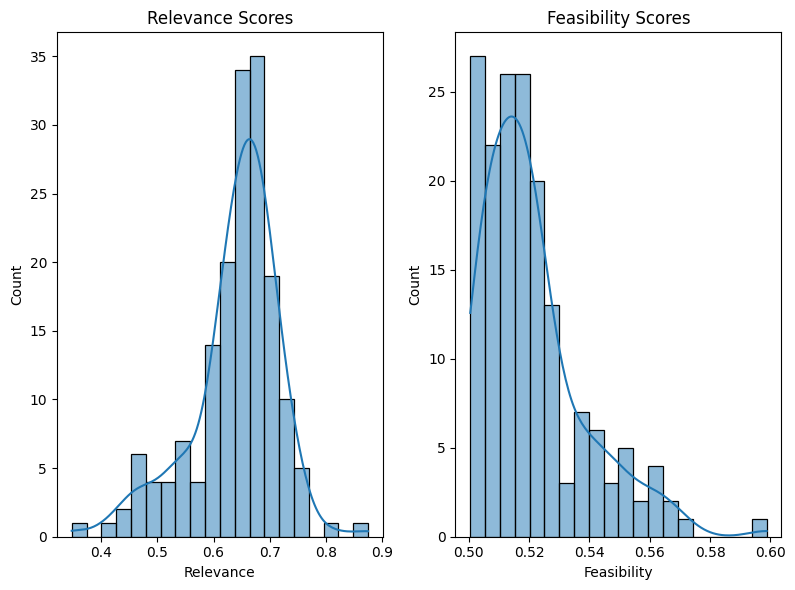

Step 3: Statistics visualized and saved as 'hypotheses_statistics.png


In [ ]:
# Step 3: Inference and Visualization

high_feasibility_percentage = (df_ideas['Feasibility'] > 0.5).mean() * 100

print(f"Percentage of High Feasibility Ideas: {high_feasibility_percentage:.2f}%")

# Visualize distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(df_ideas['Relevance'], bins=20, kde=True)
plt.title("Relevance Scores")

plt.subplot(1, 3, 2)
sns.histplot(df_ideas['Feasibility'], bins=20, kde=True)
plt.title("Feasibility Scores")

plt.tight_layout()
plt.savefig(config.STAT_IMAGE_PATH)
plt.show()
print("Step 3: Statistics visualized and saved as 'hypotheses_statistics.png")